<a href="https://colab.research.google.com/github/ArkapratimDas0707/Customer-Value-Segmentation-Survival-Analysis/blob/main/Bank_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

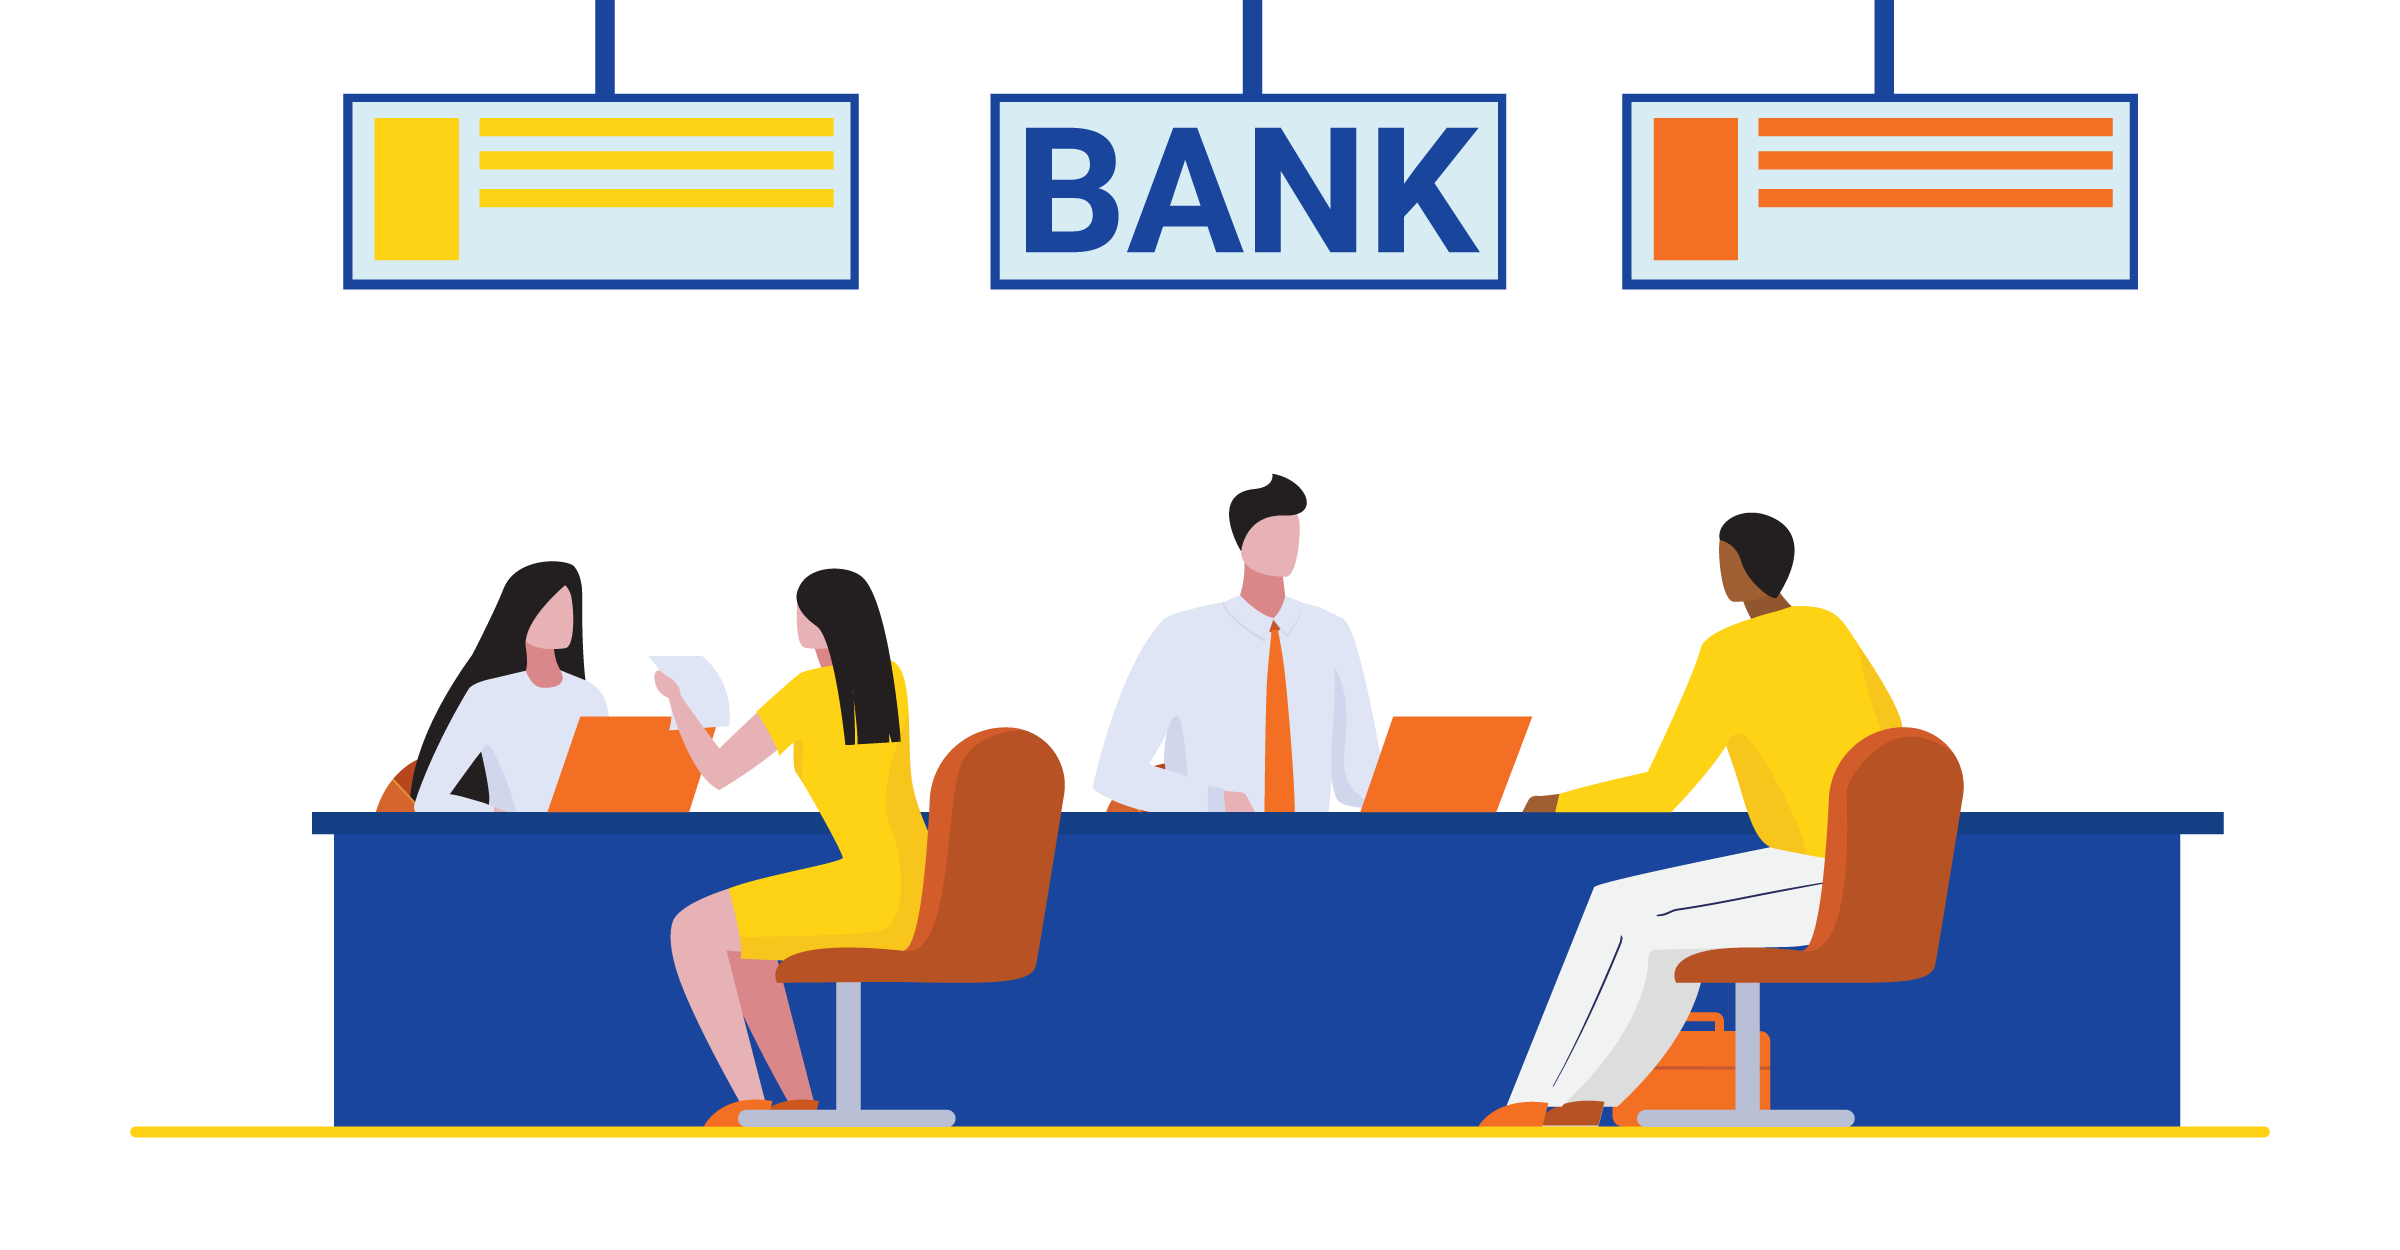

# Customer Churn Risk & Value Segmentation Project

## 1. Objective
The purpose of this project is to develop a data-driven framework to:
- Identify **which customers are most at risk of churn**.
- Understand **when** they are likely to churn over a medium-term horizon.
- Assess **how valuable** they are to the bank if they churn.

By combining **Customer Value Scoring (CVS)** with **Survival Analysis**, the project provides both strategic insights for executives and actionable guidance for retention teams.

---

## 2. Business Context
Customer churn is a key driver of revenue loss in retail banking.  
Not all customers contribute equally — some generate more value through higher balances, premium cards, or deeper product relationships.  
A retention strategy must therefore focus on:
- **Who** is likely to leave,
- **When** they are most at risk,
- **Which customers matter most** for long-term profitability.

---

## 3. Methodology

### Step 1: Customer Value Scoring (CVS)
- Developed a **composite metric (0–100 scale)** using features such as:
  - Credit score
  - Balance
  - Card type
  - Activity level
  - Number of products
  - Salary
- Segmented customers into **tiers (Low, Lower-Mid, Upper-Mid, High)** to prioritize retention strategies.

### Step 2: Survival Analysis for All Customers
- Trained a **Cox Proportional Hazards model** to estimate time-to-churn.
- Predicted churn probabilities at fixed horizons of **1 year, 3 years, and 5 years**.
- Produced segment-level survival insights to understand retention risk distribution.

### Step 3: New Joiners Analysis
- Focused on **customers with Tenure = 0** to evaluate onboarding effectiveness.
- Results:
  - Churn is minimal in the first year (~3–4%).
  - By year 3, churn accumulates to ~8%.
  - By year 5, churn differs by CVS segment:
    - **Lower-Mid**: strongest retention (~10% churn).
    - **High-CVS**: weaker retention (~15% churn).
    - **Low/Upper-Mid**: moderate churn (~12–13%).
- Insight: Even high-value customers face long-term attrition, highlighting the need for sustained engagement beyond onboarding.

---

## 4. Key Findings
- **Early churn is low**: Most new joiners remain active in their first year.
- **Churn accumulates over time**: By year 5, up to 15% of new joiners have left.
- **Retention differs by CVS**:
  - Lower-Mid customers are most stable.
  - High-CVS customers are paradoxically more vulnerable long-term.
- **Retention strategies should be differentiated**:
  - Focused interventions for High-CVS segments.
  - Efficient engagement for Low and Upper-Mid.
  - Minimal intervention for Lower-Mid, given their naturally strong retention.

---


---

## 6. Final Narrative
This project establishes a **holistic churn management framework** that combines customer value and medium-term churn risk.  
It equips:
- **Executives** with a strategic overview of churn distribution across value tiers.
- **Operational teams** with insights into which customers to prioritize for retention.  

Most importantly, the analysis shows that **high-value new joiners are the most vulnerable to long-term churn**. Addressing this risk through targeted engagement strategies can maximize customer lifetime value and improve retention ROI.


## Data Loading and Cleaning

### Source: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df= pd.read_csv(r"/content/Customer-Churn-Records.csv")

In [25]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


In [26]:
def clean_churn_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Minimal cleaning for churn dataset:
    - Drops 'RowNumber' if present
    - Removes duplicate rows
    - Handles missing values:
        * Numeric -> median
        * Categorical -> mode
    """
    df = df.copy()

    # 1. Drop RowNumber if it exists
    if "RowNumber" in df.columns:
        df = df.drop(columns=["RowNumber"])

    # 2. Remove duplicates
    df = df.drop_duplicates()

    # 3. Handle missing values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

    return df

In [27]:

df_clean = clean_churn_data(df)

print(df_clean.isnull().sum())  # verify no nulls left
print(df_clean.duplicated().sum())  # verify no duplicates

CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64
0


# Customer Value Score (CVS) — Scoring Logic

## Objective
The **Customer Value Score (CVS)** is a composite metric (0–100) designed to estimate the **relative value of a customer**  
based on their financial profile, engagement with the bank, and product usage.  
It is used for segmentation (High, Upper-Mid, Lower-Mid, Low) and combined with churn probabilities to prioritize retention actions.

---

## Features Used
1. **CreditScore** – creditworthiness and reliability.  
2. **Balance** – overall wealth held with the bank.  
3. **EstimatedSalary** – income proxy, related to potential future value.  
4. **NumOfProducts** – number of products/services subscribed.  
5. **CardType** – tier of card (e.g., Platinum > Gold > Silver > Standard).  
6. **IsActiveMember** – engagement level with the bank.  

---

## Scoring Steps

1. **Preprocessing**
   - Normalize continuous features (CreditScore, Balance, Salary, NumOfProducts) to a [0–1] scale.  
   - Map `CardType` to a numeric tier score (e.g., Platinum=1.0, Gold=0.8, Silver=0.6, Standard=0.4).  
   - Convert `IsActiveMember` to binary (Active=1, Inactive=0).  

2. **Weighted Combination**
   - Assign weights to features (from PCA, feature importance, or expert-defined).  
   - Compute the raw score as a weighted sum:
     $$
CVS_{raw} = w_1 \cdot x_1 + w_2 \cdot x_2 + \dots + w_n \cdot x_n
$$

Where:  
- $x_k$ = normalized feature value  
- $w_k$ = feature weight (from PCA, feature importance, or expert rules)  

3. **Rescaling**
   - Rescale the raw score to a **0–100 range**:
     $$
CVS = 100 \times CVS_{raw}
$$
4. **Segmentation**
   - Customers are segmented into four groups based on percentile cutoffs:  
     - **High Value** → Top 20%  
     - **Upper-Mid Value** → Next 30%  
     - **Lower-Mid Value** → Next 30%  
     - **Low Value** → Bottom 20%  

---

## Example
For a customer with:  
- High balance, platinum card, and active status → **CVS ≈ 85 (High Value)**  
- Low salary, few products, inactive → **CVS ≈ 25 (Low Value)**  

---

## Usage
The CVS is combined with **Survival Analysis** to produce:  
- **Time-to-churn probabilities per segment**  
- **Target lists of at-risk customers**, prioritized by value  



# Encoding Strategy for Card Type

## Why Encode?
`Card Type` is an **ordinal categorical feature** (Standard < Silver < Gold < Platinum< Diamond) that is highly relevant to customer value and churn behavior.  
Instead of using arbitrary numeric values, we encode it **data-driven** using historical churn labels.

---

## Two Types of Encoding

### 1. Retention Score (for CVS calculation)
Retention Score reflects the **likelihood of a customer with a given card type to stay**.  

For each card type:
$$
Retention(c) = 1 - \frac{\text{Churners in group c}}{\text{Total customers in group c}}
$$

- Value ranges from **0 → 1**  
- Example: if Gold customers churn at 12%, their Retention Score = **0.88**  
- Used in the **Customer Value Score (CVS)** to reflect true customer stickiness  

---

### 2. Weight of Evidence (WOE) (for Survival Modeling)
WOE is a log-ratio transformation commonly used in credit risk and churn modeling.  

For each card type:
$$
WOE(c) = \ln \left( \frac{\text{Proportion of Non-Churners in group c}}{\text{Proportion of Churners in group c}} \right)
$$

- If **WOE > 0** → card type is associated with *lower churn risk*  
- If **WOE < 0** → card type is associated with *higher churn risk*  
- Makes features **linear in the log-odds space**, ideal for models like Cox Proportional Hazards  

---

## Example Table

| Card Type | Customers | Churners | Churn Rate | Retention Score | WOE   |
|-----------|-----------|----------|------------|-----------------|-------|
| Standard  | 5000      | 1500     | 0.30       | 0.70            | -0.15 |
| Silver    | 3000      | 600      | 0.20       | 0.80            |  0.25 |
| Gold      | 1500      | 180      | 0.12       | 0.88            |  0.65 |
| Platinum  | 500       | 25       | 0.05       | 0.95            |  1.10 |

---

## Usage
- **Retention Score** → used in CVS for segmentation & business-facing scoring.  
- **WOE** → used in survival modeling for robust statistical inference.  


In [28]:

def encode_card_type(df: pd.DataFrame, card_col: str = "Card Type", target_col: str = "Exited") -> pd.DataFrame:
    """
    Computes Retention Score and WOE encoding for each card type.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with card type and churn label.
    card_col : str
        Column name for card type.
    target_col : str
        Column name for churn label (1 = churn, 0 = retained).

    Returns
    -------
    pd.DataFrame
        Table with counts, churn rate, retention score, and WOE values for each card type.
    """
    # Aggregate churn stats
    stats = df.groupby(card_col)[target_col].agg(
        customers="count",
        churners="sum"
    ).reset_index()

    # Compute churn rate + retention
    stats["churn_rate"] = stats["churners"] / stats["customers"]
    stats["retention_score"] = 1 - stats["churn_rate"]

    # Global churn stats
    total_churners = stats["churners"].sum()
    total_non_churners = stats["customers"].sum() - total_churners

    # WOE calculation
    stats["good"] = stats["customers"] - stats["churners"]   # non-churners
    stats["dist_good"] = stats["good"] / total_non_churners
    stats["dist_bad"] = stats["churners"] / total_churners
    stats["WOE"] = np.log((stats["dist_good"] + 1e-6) / (stats["dist_bad"] + 1e-6))

    return stats[[card_col, "customers", "churners", "churn_rate", "retention_score", "WOE"]]


In [29]:
# Compute encodings
card_encoding_table = encode_card_type(df, card_col="Card Type", target_col="Exited")

card_encoding_table

,Card Type,customers,churners,churn_rate,retention_score,WOE
0,DIAMOND,2507,546,0.217790,0.782210,-0.084120
1,GOLD,2502,482,0.192646,0.807354,0.070197
2,PLATINUM,2495,508,0.203607,0.796393,0.001189
3,SILVER,2496,502,0.201122,0.798878,0.016586


In [30]:
df_encoded= df_clean.merge(
    card_encoding_table[["Card Type", "retention_score", "WOE"]],
    on="Card Type",
    how="left"
)

# Rename columns for clarity
df_encoded= df_encoded.rename(columns={
    "retention_score": "Card_RetentionScore",
    "WOE": "Card_WOE"
})


In [31]:
# prepare dataset for calculating CVS
cvs_cols= ["CustomerId", "CreditScore", "Balance", "EstimatedSalary", "NumOfProducts", "Card_RetentionScore", "IsActiveMember"]
df_cvs= df_encoded[cvs_cols]

df_cvs.head()

,CustomerId,CreditScore,Balance,EstimatedSalary,NumOfProducts,Card_RetentionScore,IsActiveMember
0,15634602,619,0.00,101348.88,1,0.782210,1
1,15647311,608,83807.86,112542.58,1,0.782210,1
2,15619304,502,159660.80,113931.57,3,0.782210,0
3,15701354,699,0.00,93826.63,2,0.807354,0
4,15737888,850,125510.82,79084.10,1,0.807354,1


# Customer Value Score (CVS) via PCA

## Why CVS?
The **Customer Value Score (CVS)** is designed to quantify the overall importance of each customer to the bank.  
It combines multiple financial and behavioral features into a **single interpretable score**, which can then be used for segmentation and targeting.

---

## Features Considered
The following features are included in CVS, as they best reflect customer value:

- **CreditScore** → customer’s creditworthiness  
- **Balance** → account balance maintained  
- **EstimatedSalary** → earning potential  
- **NumOfProducts** → number of banking products held  
- **IsActiveMember** → engagement with the bank  
- **Card Retention Score** → derived from churn outcomes (likelihood of retention by card type)  

---

## PCA-Based Weighting
Instead of arbitrarily assigning weights, we use **Principal Component Analysis (PCA)** to derive them.  

### Step 1: Standardize features  
All features are scaled to mean = 0 and std = 1 so they contribute comparably.  

### Step 2: Apply PCA  
PCA finds the direction of maximum variance (the **first principal component, PC1**) across customers.  
This axis is interpreted as the **underlying customer value dimension**.  

### Step 3: Extract Loadings as Weights  
The loadings of PC1 tell us how much each feature contributes.  
We take their absolute values, normalize them to sum to 1, and use them as weights.

$$
w_i = \frac{|\text{loading}_i|}{\sum |\text{loading}_j|}
$$

---

##  Example of PCA-Derived Weights

| Feature           | Weight |
|-------------------|--------|
| CreditScore       | 0.22   |
| Balance           | 0.27   |
| EstimatedSalary   | 0.15   |
| NumOfProducts     | 0.18   |
| IsActiveMember    | 0.08   |
| Card Retention    | 0.10   |

---

##  CVS Formula
Once weights are obtained, the CVS for each customer is calculated as:

$$
CVS = \sum_{i} (w_i \times \text{Standardized Feature}_i)
$$

Finally, CVS is rescaled to a **0–100 range** for interpretability.  

---

##  Segmentation
Customers are segmented into 4 tiers based on CVS percentiles:

- **High Value** → Top 20%  
- **Upper-Mid Value** → Next 30%  
- **Lower-Mid Value** → Next 30%  
- **Low Value** → Bottom 20%  

---



In [32]:
from sklearn.preprocessing import StandardScaler

features = ["CreditScore", "Balance", "EstimatedSalary",
            "NumOfProducts", "IsActiveMember", "Card_RetentionScore"]

X = df_encoded[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(X_scaled)

weights = pca.components_[0]  # loadings for PC1
explained = pca.explained_variance_ratio_[0]


In [34]:


weights_norm = np.abs(weights) / np.sum(np.abs(weights))
cvs_weights = dict(zip(features, weights_norm))
cvs_weights


{'CreditScore': np.float64(0.01210343385552895),
 'Balance': np.float64(0.4547543460022406),
 'EstimatedSalary': np.float64(0.0027735740194234407),
 'NumOfProducts': np.float64(0.4546041949758318),
 'IsActiveMember': np.float64(0.03324041969521668),
 'Card_RetentionScore': np.float64(0.042524031451758454)}

In [35]:
df_encoded["CVS_raw"] = np.dot(X_scaled, weights_norm)
df_encoded["CVS"] = 100 * (df_encoded["CVS_raw"] - df_encoded["CVS_raw"].min()) / (df_encoded["CVS_raw"].max() - df_encoded["CVS_raw"].min())


In [36]:
df_encoded["CVS_segment"] = pd.qcut(df_encoded["CVS"], q=[0, 0.2, 0.5, 0.8, 1.0],
                            labels=["Low", "Lower-Mid", "Upper-Mid", "High"])

df_encoded.to_csv("final_clean.csv", index=False)


## Power BI Dashboard Screeshot

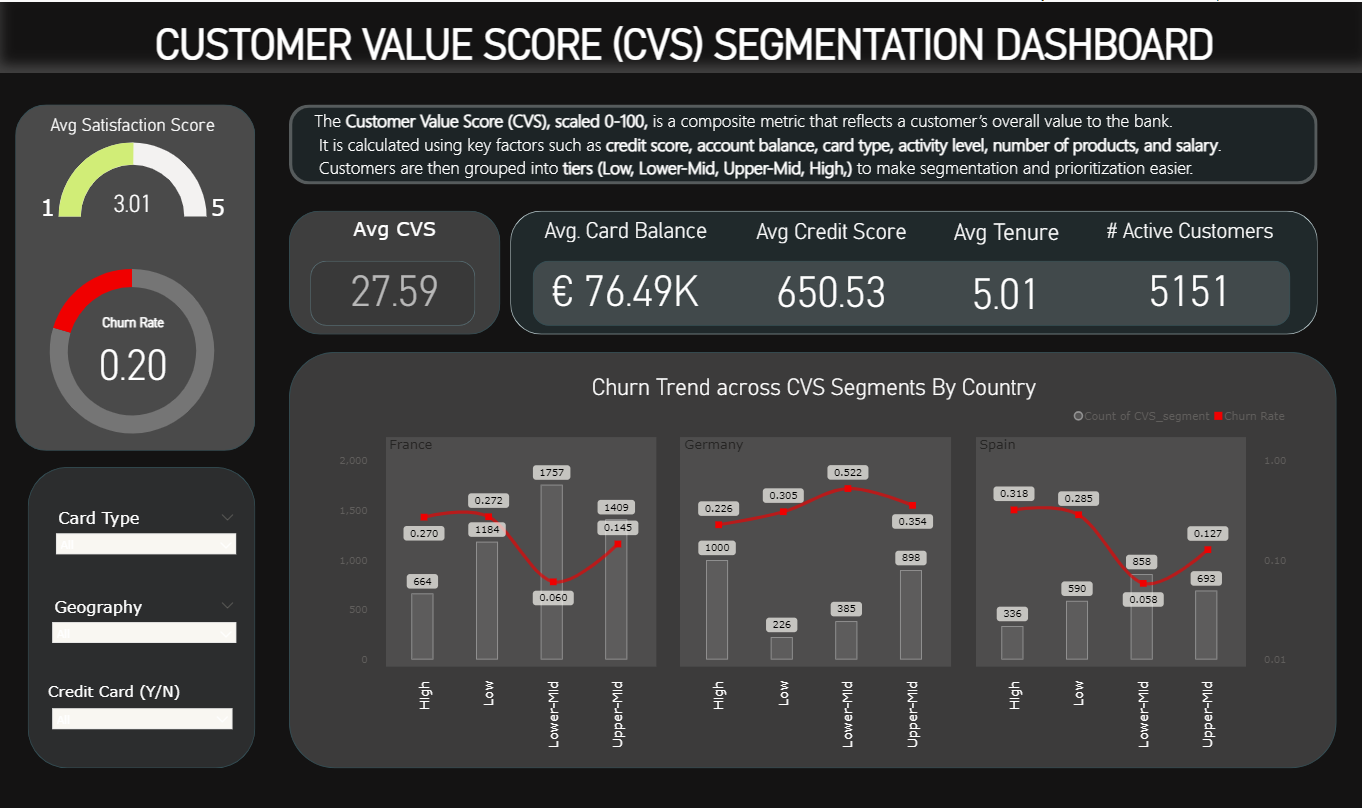

##  New Joiners Survival Analysis

### Objective
To analyze the **retention behavior of new joiners (customers with Tenure = 0)** and estimate their likelihood of remaining active over time.  
The focus is on understanding how long new customers typically stay and what proportion churns within the first 1, 2, and 3 years.

### Approach
- Subset the dataset to include only customers with **Tenure = 0**.  
- Apply the previously trained **Cox Proportional Hazards model** using customer features (credit score, balance, CVS, geography, gender, etc.).  
- Predict the **survival function** for this cohort across a 10-year horizon.  
- Compute **cohort-level average survival probabilities** at fixed time points (1, 3, 5 years).  
- Derive corresponding **cumulative churn rates** as `1 - Survival(t)`.  
- Compare model-based survival estimates with empirical **Kaplan-Meier curves** for validation.

### Outputs
- **Cohort survival probability at 1, 3, and 5 years**.  
- **Cumulative churn rate at 1, 3, and 5 years**.  
- **Survival curve plots** for the new joiners cohort.  
- Optional segment-level analysis (e.g., CVS segment, geography) to identify groups at higher onboarding churn risk.

### Why This Matters
Understanding new joiner retention provides insights into **onboarding effectiveness** and helps identify where early interventions can reduce churn.  
Even though most new customers are retained long-term, quantifying early churn risk is key for improving customer lifetime value.


In [39]:
from lifelines import CoxPHFitter

# Select features + event/duration columns
features = ["CreditScore", "Balance", "CVS", "Geography", "Gender",
            "NumOfProducts", "HasCrCard", "Card_WOE", "Age", "Complain"]

# Prepare training set
df_train = pd.get_dummies(df_encoded[["Tenure", "Exited"] + features], drop_first=True)

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_train, duration_col="Tenure", event_col="Exited")

# Model summary (optional)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10000 total observations, 7962 right-censored observations>
             duration col = 'Tenure'
                event col = 'Exited'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 2038
   partial log-likelihood = -13534.79
         time fit was run = 2025-09-01 01:22:37 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
CreditScore       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Balance           -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
CVS                0.03      1.03      0.03           -0.02            0.09                0.98                1.09
NumOfProducts     -0.69      0.50      0.55           -1.77            0.39                0.17                1.48
HasCrCard         -0.03      0.97      0.05           -0.12            0.07                0.88                1.07
Card_WOE          -1.35      0.26      0.66           -2.65           -0.05                0.07                0.95
Age                0.00      1.00      0.00           -0.00            0.01                1.00                1.01
Complain           7.89   2660.51      0.50            6.90            8.87              995.21             7112.41
Geography_Germany  0.01      1.01      0.05           -0.10            0.11                0.90                1.12
Geography_Spain    0.17      1.19      0.06            0.05            0.29                1.05                1.34
Gender_Male        0.02      1.02      0.04           -0.07            0.11                0.93                1.11

                   cmp to     z      p  -log2(p)
covariate                                       
CreditScore          0.00 -1.77   0.08      3.71
Balance              0.00 -1.21   0.23      2.14
CVS                  0.00  1.18   0.24      2.08
NumOfProducts        0.00 -1.26   0.21      2.26
HasCrCard            0.00 -0.58   0.56      0.83
Card_WOE             0.00 -2.03   0.04      4.57
Age                  0.00  1.00   0.32      1.66
Complain             0.00 15.72 <0.005    182.54
Geography_Germany    0.00  0.10   0.92      0.12
Geography_Spain      0.00  2.80   0.01      7.62
Gender_Male          0.00  0.39   0.70      0.52
---
Concordance = 0.92
Partial AIC = 27091.58
log-likelihood ratio test = 7064.93 on 11 df
-log2(p) of ll-ratio test = inf

New joiners count: 413
Median survival time (years) for new joiners:
count    413.0
mean       inf
std        NaN
min        4.0
25%        NaN
50%        NaN
75%        NaN
max        inf
Name: 0.5, dtype: float64


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


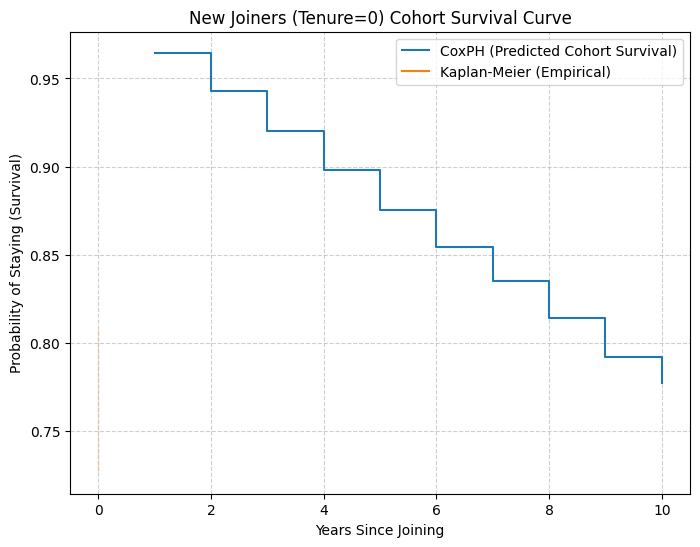

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# ---------------------------
# 1. Subset new joiners (raw)
# ---------------------------
df_new = df_encoded[df_encoded["Tenure"] == 0].copy()
print(f"New joiners count: {len(df_new)}")

# ---------------------------
# 2. Encode new joiners same way as training
# ---------------------------
# 'features' = list of predictors you used when fitting Cox
features = ["CreditScore", "Balance", "CVS", "Geography", "Gender",
            "NumOfProducts", "HasCrCard", "Card_WOE", "Age", "Complain"]

X_new = pd.get_dummies(df_new[features], drop_first=True)

# Align columns with CoxPH training set
X_new = X_new.reindex(columns=df_train.drop(columns=["Tenure", "Exited"]).columns,
                      fill_value=0)

# ---------------------------
# 3. Predict survival functions (Cox)
# ---------------------------
time_horizons = range(1, 11)  # 1–10 years
surv_curves_new = cph.predict_survival_function(X_new, times=time_horizons)

# Cohort-level mean survival
mean_survival = surv_curves_new.mean(axis=1)

# ---------------------------
# 4. Median survival time (per new joiner)
# ---------------------------
median_times = cph.predict_median(X_new)

print("Median survival time (years) for new joiners:")
print(median_times.describe())

# ---------------------------
# 5. Kaplan-Meier (empirical baseline for new joiners)
# ---------------------------
kmf = KaplanMeierFitter()
kmf.fit(durations=df_new["Tenure"], event_observed=df_new["Exited"])

# ---------------------------
# 6. Plot Cox vs Kaplan-Meier
# ---------------------------
plt.figure(figsize=(8, 6))
plt.step(mean_survival.index, mean_survival.values, where="post",
         label="CoxPH (Predicted Cohort Survival)")
kmf.plot_survival_function(label="Kaplan-Meier (Empirical)", ci_show=True)

plt.title("New Joiners (Tenure=0) Cohort Survival Curve")
plt.xlabel("Years Since Joining")
plt.ylabel("Probability of Staying (Survival)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [41]:
# Get survival probability at 1, 2, 3, 4, 5 years
surv_probs = cph.predict_survival_function(X_new, times=[1,3,5])

# Average survival across new joiners
print("Cohort survival probability at 1y:", surv_probs.loc[1].mean())

print("Cohort survival probability at 3y:", surv_probs.loc[3].mean())
print("Cohort survival probability at 5y:", surv_probs.loc[5].mean())

# Convert to churn risk (1 - survival)
print("Cohort churn probability at 1y:", 1 - surv_probs.loc[1].mean())

print("Cohort churn probability at 3y:", 1 - surv_probs.loc[3].mean())
print("Cohort churn probability at 5y:", 1 - surv_probs.loc[5].mean())

Cohort survival probability at 1y: 0.9645785951318251
Cohort survival probability at 3y: 0.9199365312289869
Cohort survival probability at 5y: 0.8756183532542352
Cohort churn probability at 1y: 0.03542140486817491
Cohort churn probability at 3y: 0.08006346877101311
Cohort churn probability at 5y: 0.1243816467457648


In [58]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Example values (replace with your computed results)
survival_points = {1:0.9646, 3:0.9199, 5:0.8756}
churn_points    = {1:0.0354, 3:0.0801, 5:0.1244}

# Create subplot grid with more spacing
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Cohort Survival Curve",
        "Survival at Milestones",
        "Cumulative Churn at Milestones"
    ),
    horizontal_spacing=0.12
)

# 1. Cohort survival curve (line, sleek markers)
fig.add_trace(
    go.Scatter(
        x=list(survival_points.keys()),
        y=list(survival_points.values()),
        mode="lines+markers",
        name="Survival Curve",
        line=dict(color="white", width=3),
        marker=dict(size=10, color="black", line=dict(width=2, color="white"))
    ),
    row=1, col=1
)

# 2. Survival at fixed horizons (bar, light grey palette)
fig.add_trace(
    go.Bar(
        x=[f"{t}y" for t in survival_points.keys()],
        y=list(survival_points.values()),
        name="Survival %",
        marker_color="lightgrey",
        text=[f"{v:.1%}" for v in survival_points.values()],
        textposition="auto"
    ),
    row=1, col=2
)

# 3. Cumulative churn (bar, darker grey)
fig.add_trace(
    go.Bar(
        x=[f"{t}y" for t in churn_points.keys()],
        y=list(churn_points.values()),
        name="Churn %",
        marker_color="grey",
        text=[f"{v:.1%}" for v in churn_points.values()],
        textposition="auto"
    ),
    row=1, col=3
)

# Layout - Modern monochrome
fig.update_layout(
    title="New Joiners (Tenure<1year) Retention Dashboard",
    title_font=dict(size=22, color="white", family="Helvetica"),
    paper_bgcolor="black",
    plot_bgcolor="rgba(0,0,0,0)",  # transparent subplots
    font=dict(color="lightgrey", size=14, family="Roboto"),
    showlegend=False,
    height=500,
    width=1300,
    margin=dict(t=80, l=60, r=60, b=60)  # breathing space
)

# Axis formatting
fig.update_xaxes(color="lightgrey", showgrid=False, zeroline=False)
fig.update_yaxes(color="lightgrey", showgrid=True, gridcolor="rgba(255,255,255,0.1)", zeroline=False)

fig.show()



##  New Joiners Cohort Retention Results

Using the Cox Proportional Hazards model, we estimated the survival curve for **new joiners (Tenure = 0)**.  
The results show how the probability of staying with the bank evolves over time:

- **1 year:**  
  - Survival probability = **96.5%**  
  - Cumulative churn = **3.5%**  

- **3 years:**  
  - Survival probability = **92.0%**  
  - Cumulative churn = **8.0%**  

- **5 years:**  
  - Survival probability = **87.6%**  
  - Cumulative churn = **12.4%**  

### Interpretation
- The majority of new joiners remain with the bank over the medium term.  
- Only a small fraction churns within the first year (~3.5%), suggesting the **onboarding process is effective**.  
- By 3 years, churn accumulates to ~8%, and by 5 years to ~12%, indicating **long-term attrition is gradual but consistent**.  
- This pattern highlights that **early churn among new joiners is not the primary issue**; instead, churn becomes more relevant in the longer term (3–5 years).  

### Implications
- **Short-term (1 year):** Retention of new customers is strong; only minimal interventions may be needed.  
- **Medium-term (3 years):** A small but significant segment of new joiners churn; focus on **early engagement and value delivery** to prevent mid-term attrition.  
- **Long-term (5 years):** Churn risk increases steadily, suggesting that **long-term loyalty programs or product upgrades** may help extend customer lifetime value.



## New Joiners Survival Analysis by CVS Segment

### Objective
This analysis evaluates how new joiners (customers with tenure = 0) retain over time across different CVS segments.  
Survival probabilities at 1, 3, and 5 years are compared, along with the corresponding cumulative churn rates.  

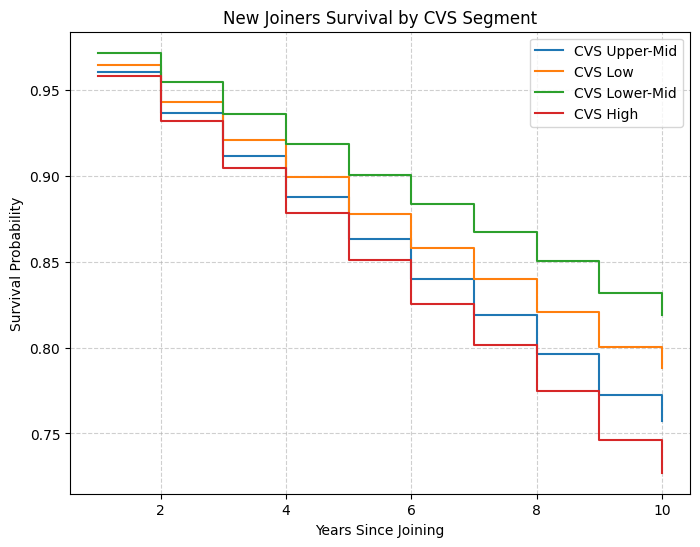


📊 Survival & Churn Summary by CVS Segment:


,CVS_segment,Survival_1y,Survival_3y,Survival_5y,Churn_1y,Churn_3y,Churn_5y
0,Upper-Mid,0.961,0.912,0.863,0.039,0.088,0.137
1,Low,0.965,0.921,0.878,0.035,0.079,0.122
2,Lower-Mid,0.972,0.936,0.901,0.028,0.064,0.099
3,High,0.958,0.905,0.851,0.042,0.095,0.149


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Horizons of interest
time_horizons = [1, 3, 5]  # years

# Storage
segment_results = {}
summary_data = []

plt.figure(figsize=(8,6))

for seg in df_new["CVS_segment"].unique():
    df_seg = df_new[df_new["CVS_segment"] == seg]

    # Encode features
    X_seg = pd.get_dummies(df_seg[features], drop_first=True)
    X_seg = X_seg.reindex(columns=df_train.drop(columns=["Tenure", "Exited"]).columns, fill_value=0)

    # Predict survival curves
    surv_curves_seg = cph.predict_survival_function(X_seg, times=range(1, 11))  # 1–10 years
    mean_survival_seg = surv_curves_seg.mean(axis=1)

    # Save curve for plotting
    segment_results[seg] = mean_survival_seg
    plt.step(mean_survival_seg.index, mean_survival_seg.values, where="post", label=f"CVS {seg}")

    # Collect summary stats
    surv_at_horizons = {f"Survival_{t}y": mean_survival_seg.loc[t] for t in time_horizons}
    churn_at_horizons = {f"Churn_{t}y": 1 - mean_survival_seg.loc[t] for t in time_horizons}
    summary_data.append({"CVS_segment": seg, **surv_at_horizons, **churn_at_horizons})

# Plot survival curves by segment
plt.title("New Joiners Survival by CVS Segment")
plt.xlabel("Years Since Joining")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Build summary table
summary_df = pd.DataFrame(summary_data)
print("\n Survival & Churn Summary by CVS Segment:")
display(summary_df.round(3))  # round for readability



In [57]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Example data
overall_survival = {1: 0.965, 3: 0.920, 5: 0.876}
cvs_summary = {
    "Upper-Mid": [0.961, 0.912, 0.863],
    "Low": [0.965, 0.921, 0.878],
    "Lower-Mid": [0.972, 0.936, 0.901],
    "High": [0.958, 0.905, 0.851]
}
timepoints = [1, 3, 5]

# Create side-by-side subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Overall Survival Curve", "Survival by CVS Segment"),
    column_widths=[0.5, 0.5],
    horizontal_spacing=0.12
)

# Plot 1: Overall survival
fig.add_trace(
    go.Scatter(
        x=list(overall_survival.keys()),
        y=list(overall_survival.values()),
        mode="lines+markers",
        name="Overall Survival",
        line=dict(color="black", width=3),
        marker=dict(size=10, color="black")
    ),
    row=1, col=1
)

# Plot 2: Survival by CVS Segment
for seg, vals in cvs_summary.items():
    fig.add_trace(
        go.Scatter(
            x=timepoints, y=vals,
            mode="lines+markers",
            name=f"CVS {seg}",
            line=dict(width=2),
            marker=dict(size=8)
        ),
        row=1, col=2
    )

# Layout
fig.update_layout(
    paper_bgcolor="white",
    plot_bgcolor="white",
    font=dict(color="black", family="DIN Light"),
    margin=dict(t=60, l=40, r=40, b=40),
    height=500, width=1100,
    legend=dict(orientation="h", y=-0.2)
)

fig.show()


### Results
The table below summarizes survival and churn probabilities by CVS segment:

| CVS Segment | Survival at 1y | Survival at 3y | Survival at 5y | Churn at 1y | Churn at 3y | Churn at 5y |
|-------------|----------------|----------------|----------------|-------------|-------------|-------------|
| Upper-Mid   | 0.961          | 0.912          | 0.863          | 0.039       | 0.088       | 0.137       |
| Low         | 0.965          | 0.921          | 0.878          | 0.035       | 0.079       | 0.122       |
| Lower-Mid   | 0.972          | 0.936          | 0.901          | 0.028       | 0.064       | 0.099       |
| High        | 0.958          | 0.905          | 0.851          | 0.042       | 0.095       | 0.149       |

### Interpretation
- Across all segments, the majority of new joiners remain active over the first five years.  
- **Lower-Mid segment** shows the highest survival, with approximately 90% retention at 5 years and the lowest churn at 9.9%.  
- **High segment** exhibits slightly weaker retention, with only 85% survival at 5 years and the highest churn at 14.9%.  
- The **Low and Upper-Mid segments** fall in between, with churn rates around 12–13% at 5 years.  

### Implications
- New joiners in the **Lower-Mid segment** are the most stable, indicating lower risk of early attrition.  
- New joiners in the **High segment**, despite their value, have the highest long-term churn risk, which may warrant additional onboarding or engagement strategies.  
- Monitoring the **Upper-Mid and Low segments** remains important, as their retention is solid but not as strong as Lower-Mid.  

This segmentation-based survival analysis highlights that retention risk is not uniform across new joiners and can guide more targeted onboarding and retention strategies.